# Style generation with IMDb data

We are going to loosely follow the fast.ai tutorial on fine-tuning a model to classify IMDb reviews. The original code is [here](https://github.com/fastai/fastai/blob/master/courses/dl2/imdb.ipynb). Since we're just interested in fine-tuning a language model to do text generation, we're going to ignore all the stuff about classes/labels/classifiers and just focus on the language model.

In [2]:
from fastai_old.text import *
import html
import spacy 

spacy.load('en')

## Get data

We need to download the IMDB large movie reviews from this site: http://ai.stanford.edu/~amaas/data/sentiment/ Direct link : Link and untar it into the PATH location. We use pathlib which makes directory traveral a breeze.

In [3]:
DATA_PATH=Path('data/')
DATA_PATH.mkdir(exist_ok=True)
#! curl -O http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz 
#! tar -xzfv aclImdb_v1.tar.gz -C {DATA_PATH}

BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/aclImdb/')

The imdb dataset has 3 classes. positive, negative and unsupervised(sentiment is unknown). There are 75k training reviews(12.5k pos, 12.5k neg, 50k unsup) There are 25k validation reviews(12.5k pos, 12.5k neg & no unsup).

Refer to the README file in the imdb corpus for further information about the dataset.

Since we are just interested in the language model, we're going to ignore all the information about the classes/labels. And since there is so much data -- we don't want to use it all -- we are just going to look at the unsupervised reviews, where the sentiment is unknown.

In [4]:
# CLAS_PATH=Path('data/imdb_clas/')
# CLAS_PATH.mkdir(exist_ok=True)

LM_PATH=Path('data/imdb_lm/')
LM_PATH.mkdir(exist_ok=True)

We're also going to decrease the amount of data to less than 10k examples. This will speed things up and make it closer to the typical small datasets we're interested in.

In [8]:
CLASSES = ['unsup']
maxn = 8000

def get_texts(path):
    texts = []
    for idx,label in enumerate(CLASSES):
        for fname in (path/label).glob('*.*'):
            if len(texts) >= maxn:
                break
            texts.append(fname.open('r', encoding='utf-8').read())
    return np.array(texts)

all_texts = get_texts(PATH/'train')
len(all_texts)

8000

In [12]:
all_texts[0]

"A newspaperman (Johnny Twennies) living in the 90's with a complete 20's personality and lifestyle - fedora, manual typewriter, the Charleston, the works. It's a great idea for a movie and it couldn't have been done better.<br /><br />Johnny doesn't miss a cliche, but never uses the same one twice. You'll find yourself anticipating his reactions to the harsher '90s world as the movie goes along, you'll often guess right - but that makes the movie just that much more fun.<br /><br />Lots of fun when Johnny is called on to save the same damsel in distress (named Virginia, natch) on three different occasions. She responds with appropriate fluttering eyelids each time.<br /><br />His reaction to independent women, openly gay men, and the general '90s milieu is delightful. He remains happily oblivious.<br /><br />Don't worry, the movie never takes itself seriously. Nobody preaches about the evil of the present, or the shallowness of the past. You end up with a warm feeling for all the char

Let's split it into 90% train and 10% validation sets. This function is probably overkill, and makes the code unnecessarily complicated and reliant on external libraries, but whatever. Maybe I'll clean it up later.

In [11]:
trn_texts,val_texts = sklearn.model_selection.train_test_split(
    all_texts, test_size=0.1)

len(trn_texts), len(val_texts)

(7200, 800)

## Preprocess data

We're going to follow this pandas dataframe format because that's what the fast.ai tutorial uses and also because I think it makes the pre-processing go faster.

They say: "The pandas dataframe is used to store text data in a newly evolving standard format of label followed by text columns. This was influenced by a paper by Yann LeCun (LINK REQUIRED). Fastai adopts this new format for NLP datasets. In the case of IMDB, there is only one text column."

In [62]:
col_names = ['text']
df_trn = pd.DataFrame({'text':trn_texts}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts}, columns=col_names)

df_trn['text'][0]

'I was on the last hundred pages of \'Lucy Sullivan\' and had decided to put the book down - make it last. Then the thought popped into my head "There\'s a DVD set you can watch, just read it!". So i finished the book that night, really happy and excited about renting out the TV Adaption the next day.<br /><br />Now i wish I\'d savored the book, and not wasted my $10 on this crap. Not even Gerard Butler could save it. This is the worst thing i have watched since, and probably before, Gigli. The Characters are completely altered, none of the changes are positive. Too much detail is paid to things that are pointless and/or dull. The acting is awful and the entire feeling of the show leaves you empty.<br /><br />Do not bother. It\'s an insult to all things Keys!'

Now we'll create some functions that will allow us to read the data and convert it into a set of numbers, where each number represents a word. These will clean up the data.

In [60]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))

def get_texts(df):
    texts = f'\n{BOS} {FLD} 1 ' + df['text'].astype(str)
    texts = list(texts.apply(fixup).values)
    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok

In [65]:
tok_trn = get_texts(df_trn)
tok_val = get_texts(df_val) 

Let's save these so we can load them later and not have to do the pre-processing again:

In [66]:
np.save(LM_PATH/'tmp'/'tok_trn_style.npy', tok_trn)
np.save(LM_PATH/'tmp'/'tok_val_style.npy', tok_val)

In [67]:
tok_trn = np.load(LM_PATH/'tmp'/'tok_trn_style.npy')
tok_val = np.load(LM_PATH/'tmp'/'tok_val_style.npy')

Let's have a look at the most frequent words in this corpus.

In [72]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(15)

[('the', 98539),
 ('.', 80117),
 (',', 79807),
 ('and', 47831),
 ('a', 47759),
 ('of', 42673),
 ('to', 39048),
 ('is', 31584),
 ('it', 27636),
 ('in', 27298),
 ('i', 24399),
 ('this', 21666),
 ('that', 21063),
 ('"', 19562),
 ("'s", 18175)]

Okay here we're going to set our up string-to-integer dictionary and integer-to-string list for the vocab. We'll set a max and min frequency, which can be used to limit the vocabularly size.

In [69]:
max_vocab = 60000
min_freq = 2

In [70]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

In [71]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

21857

Now we're going to create these language model objects, which is a list of imbd reviews where each imdb review is a list of integers -- the words in the review (in order).

In [73]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

#### TODO: save all this, pickle itos, stoi, etc. 

In [75]:
vs=len(itos)
vs,len(trn_lm)

(21857, 7200)

## Set up pretrained model

We are going to first load a pre-trained language model. Our source LM is the wikitext103 LM created by Stephen Merity @ Salesforce research. [Link to dataset](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/).
The language model for wikitext103 (AWD LSTM) has been pre-trained and the weights can be downloaded here: [Link](http://files.fast.ai/models/wt103/). Our target LM is the style LM. 

In [76]:
# ! wget -nH -r -np -P {PATH} http://files.fast.ai/models/wt103/

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

Note that the 'models' directory should be in 'aclimbd'.

In [79]:
em_sz,nh,nl = 400,1150,3

PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

Then we load the itos and stoi for the pre-trained language model.

In [85]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

len(itos2)

238462

Not sure what happens to these words that are in the imbd reviews but *not* in the pre-trained model...

In [93]:
oov = set(itos) - set(itos2).intersection(itos)
len(oov), list(oov)[0:10]

(752,
 ['laverty',
  'sidesplitting',
  'guffman',
  'margheriti',
  'wheke',
  'lugging',
  'ripoffs',
  '\n\n',
  'b+',
  'todays'])

Before we try to transfer the knowledge from wikitext to the IMDB LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown IMDB tokens that do not exist in wikitext103.

In [83]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):                     # for word in imbd vocab
    r = stoi2[w]                                # get the int in the pretrained vocab
    new_w[i] = enc_wgts[r] if r>=0 else row_m   # add weight if in vocab, else add mean weight

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [84]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

In [94]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [95]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [96]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

In [97]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.model.load_state_dict(wgts)

In [112]:
def generate_text(m, s, l=20):
    m[0].bs=1  # Set batch size to 1
    m.eval()  # Turn off dropout
    m.reset()  # Reset hidden state
    m[0].bs=bs  # Put the batch size back to what it was

    ss = s.lower().split()
    si = [stoi[w] for w in ss]
    t = torch.autograd.Variable(torch.LongTensor(np.array([si])))
    
    res,*_ = m(t)

    print(s,"\n")
    for i in range(l):
        n = res[-1].topk(2)[1]
        n = n[1] if n.data[0]==0 else n[0]
        print(itos[n], end=' ')
        res,*_ = m(n.unsqueeze(0).unsqueeze(0))
    print('...')

In [ ]:
m=learner.model

In [113]:
generate_text(m, "The movie was")

The movie was 

named . of the 9 in the october . of the 9 in the october . the 's both 's ...


## Training!

Alright, let's do some training and see how it changes the language model...

In [107]:
learner.metrics = [accuracy]
learner.freeze_to(-1)

In [108]:
lr=1e-3
lrs = lr

In [109]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.92217    4.669553   0.238484  



[4.669552756894019, 0.2384838829598119]

In [122]:
itos_imdb = itos
with open(PRE_PATH/'itos_imdb.pkl', 'wb') as f:
    pickle.dump(itos_imdb, f)
learner.save('lm_last_ft')

In [111]:
learner.load('lm_last_ft')

In [114]:
m=learner.model

In [115]:
generate_text(m, "The movie was", l=50)

The movie was 

named . of the 9 in the october . of the 9 in the october . the 's both 's . that the up this to be society , the 000 in because that the 's the both 's . most that society it the 10 still by the 000 ...


More training!

In [116]:
learner.unfreeze()
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                          
    0      4.744716   4.561432   0.23289   



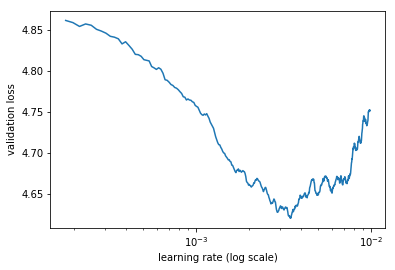

In [118]:
learner.sched.plot()

In [123]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=3)

epoch      trn_loss   val_loss   accuracy                              
    0      4.493381   4.238888   0.265202  
    1      4.283041   4.17596    0.271544                     
    2      4.170497   4.151136   0.274391                        


[4.151135825341748, 0.27439123440173363]

In [125]:
learner.save('lm_3epochs')
m=learner.model
generate_text(m, "The movie was", l=50)

The movie was 

that and other 2010 , the three a who and race in second one were old to war twin in and began one a old to war twin in song , the up same - five on 
  february found a the third - the second one were command " ...
